## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
def calibrate_camera_from_images(images, display=False):
    """ Compute a camera calibration from a set of chessboard images.
    
    This function takes a list of paths to (chessboard) image files as inputs. It computes
    a camera calibration using those images. The function estimates the intrinsic camera parameters
    and extrinsic parameters for each of the views, wrapping OpenCV's calibrateCamera function,
    based on [Zhang2000] and [BouguetMCT].
    
    Args:
        images: A list of paths to image files. The images are color, and contain chessboards.
        display (bool): Show corner detections as the images are processed.
    Returns:
        mtx: 3x3 camera matrix.
        dist:  Output vector of distortion coefficients  
    """
    # Prepare object points.
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if display:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

    if display:            
        cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

## Apply a distortion correction to raw images.

In [3]:
def display_undistorted(original_img, undistorted_img):
    """ Display an undistorted image alongside the original warped image.
   
    Args:
        original_img: The original image.
        undistored_img: The undistored image.
    """    
    cv2.imwrite('output_images/original_img.jpg',original_img)
    cv2.imwrite('output_images/undistored_img.jpg',undistorted_img)
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Original (warped) image')
    ax1.imshow(original_img)
    ax2.set_title('Undistorted image')
    ax2.imshow(undistorted_img)

## Functions to create a thresholded binary image

In [4]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255), ksize=5):
    """ Compute a thresholded gradient binary image.
    
    This function takes an input image and applies a Sobel filter in the given orientation. 
    It then applies a threshold (min & max) to the computed gradient. It returns a binary image
    where 1's denote pixels whose absolute gradient falls within the threshold.
    
    Args:
        img (numpy array): The color input image.
        orient (string, 'x' or 'y'): Which direction to calculate the gradient.
        thresh (tuple): (min, max) values of the threshold to apply.
        ksize (int): the sobel kernel size
    Returns:
        A binary image where 1s denote pixels whose absolute gradient falls within the threshold.
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        img_sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    else:
        img_sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(img_sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    img_scaled = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    img_mask = (img_scaled <= thresh[1]) & (img_scaled > thresh[0])
    binary_image = np.zeros_like(img_scaled)
    binary_image[img_mask] = 1
    # 6) Return this mask as your binary_output image
    return binary_image

def mag_thresh(img, ksize=5, mag_thresh=(0, 255)):
    """ Compute the magnitude of the gradient at each pixel and return a binary image.
    
    This function takes the gradients in both x and y of an image and computes
    the overall magnitude of the gradient. It returns a binary image with pixel
    values of 1 wherever the gradient falls between the specified threshold values.
    
    Args:
        img (numpy array): Color input image.
        ksize (int): The Sobel kernel window size to apply. Must be an odd number.
        mag_thresh (tuple): The (min, max)
    Returns:
        A binary image with 1s wherever the magnitude of the gradient falls within the
        threshold bounds, and 0s elsewhere.        
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    grad_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Calculate the magnitude 
    mag_grad = np.sqrt(np.square(grad_x) + np.square(grad_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255*mag_grad/np.max(mag_grad))
    # 5) Create a binary mask where mag thresholds are met
    img_mask = (scaled <= mag_thresh[1]) & (scaled >= mag_thresh[0])
    binary_output = np.zeros_like(img_gray)
    # 6) Return this mask as your binary_output image
    binary_output[img_mask] = 1
    return binary_output

def dir_thresh(img, ksize=5, thresh=(0, np.pi/2)):
    """Compute the direction of the gradient and return a binary image that satisfies the thresholds.
    
    This function computes the direction of the image gradient at each pixel and applies a threshold
    to it. It returns a binary image with 1s wherever the gradient direction falls within the supplied
    threshold, and 0s elsewhere.
    
    Args:
        img (numpy array): input color image,
        ksize (int): the size of the sobel kernel to apply (must be an odd number).
        thresh (tuple): the minimum and maximum thresholds.
    Returns:
        A binary image with 1s wherever the gradient direction falls within the threshold, 0s elsewhere.
        """
    # Apply the following steps to img
    # 1) Convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize)
    sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize)
    # 3) Take the absolute value of the x and y gradients
    abs_x = np.absolute(sobel_x)
    abs_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_y, abs_x)
    # 5) Create a binary mask where direction thresholds are met
    img_mask = (grad_dir <= thresh[1]) & (grad_dir >= thresh[0])
    binary_output = np.zeros_like(grad_dir)
    binary_output[img_mask]=1
    # 6) Return this mask as your binary_output image
    return binary_output

def hls_color_threshold(img, h_thresh=(0,255), s_thresh=(0,255)):
    """Compute an image that is thresholded in both the hue and saturation colorspaces of a HLS image.
    
    This function computes a binary image, with ones wherever the hue and saturation values fall within
    the user supplied thresholds.
    
    Args:
        img (numpy array): input color image,
        h_thresh (tuple): the minimum and maximum thresholds for hue.
        s_thresh (tuple): the minimum and maximum thresholds for saturation.
    Returns:
        A binary image with 1s wherever the gradient direction falls within the threshold, 0s elsewhere.
    """
    # Convert to HSV color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    # Threshold color channel
    h_binary = np.zeros_like(s_channel)
    s_binary = np.zeros_like(s_channel)
    binary_out = np.zeros_like(s_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    binary_out[(h_binary==1) & (s_binary==1)]=1
    return binary_out

def compute_thresholded_binary_img(img):
    """Compute an image that is thresholded in both gradient and color, suitable for lane detection.
    
    This function computes a binary image, with ones wherever gradient and color values fall within
    the user supplied thresholds. It thresholds the gradient in terms of magnitude and direction, and
    uses thresholds on hue and saturation in the HLS colorspace. These thresholds are combined to produce
    a binary image suitable as input to a geometric line detection pipeline.
    
    Args:
        img (numpy array): input color image,
    Returns:
        A NxNx3 image. The first channel is the output of the gradient thresholding, the second is the output
        of the color thresholding, and the third is a binaray image with the two thresholding methods combined.
        This third channel is suitable for further geometric line detection processing.
    """
    # Take a local copy of the image
    img = np.copy(img)
    gradx = abs_sobel_thresh(img, orient='x', thresh=(20,150), ksize=5)
    grady = abs_sobel_thresh(img, orient='y', thresh=(20,150), ksize=5)
    mag_binary = mag_thresh(img, ksize=5, mag_thresh=(30, 150))
    dir_binary = dir_thresh(img, ksize=5, thresh=(0.7,1.3))
    combined_grad = np.zeros_like(dir_binary)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    color_threshold = hls_color_threshold(img, h_thresh=(15,100), s_thresh=(90,255))
    pipeline_out = np.zeros_like(color_threshold)
    pipeline_out[(combined_grad==1)|(color_threshold==1)]=1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    images = np.dstack((combined_grad, color_threshold, pipeline_out))
    return images
    

In [5]:
def display_thresholding(original_img, img_out):
    """ Display an undistorted image alongside the original warped image.
   
    Args:
        original_img: The original image.
        img_out: The undistored image.
    """    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.set_title('Original image')
    ax1.imshow(original_img)
    ax2.set_title('Gradient thresholded image')
    ax2.imshow(img_out[:,:,0])
    ax3.set_title('Color thresholded image')
    ax3.imshow(img_out[:,:,1])
    ax4.set_title('Combined Thresholds')
    ax4.imshow(img_out[:,:,2])
    
    cv2.imwrite('output_images/gradient_thresholded_img.jpg',img_out)
    cv2.imwrite('output_images/color_thresholded_img.jpg',img_out[:,:,1])
    cv2.imwrite('output_images/combined_thresholded_img.jpg',img_out[:,:,2])

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [6]:
def perspective_rectify(img):
    """Choose a trapezoidal portion from the lower portion of the image,
       that encompasses the lane lines. Use a perspective transform to
       warp the original image into a birds-eye view top down perspective.
       This allows for easier computation of the curvature of the lines.
       
       Args:
           img: The original image (can be color or grayscale)
    """
    
    # Choose offset from image corners to plot corners of the trapezoid.
    # This should be chosen to present the result at the proper aspect ratio
    offset = 120
    
    # Thresholds for drawing a trapezoid around the likely position of the lane
    # lines in the source image.
    # NB The camera being mounted in the center of the windscreen is assumed here.
    xoffset=100  # The pixel distance in from the left and right edges.
    x_add=100    # How wide to go left and right of the center at the top of the trapezoid
    y_top=450    # In y coords, where to draw the top of the trapezoid
    x_center = img.shape[1]/2  # The center of the image
    y_bottom = img.shape[0]    # The bottom of the trapezoid lines up with the bottom edge of the image.

    # Specify a trapezoid in the source image that contains the lane lines of the lane
    # we're in.
    src = [(xoffset ,y_bottom), (x_center-x_add, y_top), (x_center+x_add, y_top), 
           (img.shape[1]-xoffset, y_bottom)] 

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result. 
    
    dst = np.float32(
        [(offset,img.shape[0]),
         (offset,0),
         (img.shape[1]-offset, 0),
         (img.shape[1]-offset,img.shape[0])])
    
    M = cv2.getPerspectiveTransform(np.asarray(src, np.float32), dst)
    
    # The size of the output image.
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped, src, M

def display_perspective_transform(original_img, src, transformed_img):
    """ Show a before and after view of the transform.
    
    Args:
        original_image: The original (unwarped) image.
        src: The area of the original image which defines the source points for the transform.
        transformed_image: The image after the perspective warp is applied.
    """
    codes = [Path.MOVETO,
             Path.LINETO,
             Path.LINETO,
             Path.LINETO,
             Path.CLOSEPOLY,
             ]

    # Close off the polygon.
    src.extend([src[0]])
    path = Path(src, codes)

    f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(original_img)
    patch = patches.PathPatch(path, facecolor='orange', lw=2, alpha=0.5)
    ax1.add_patch(patch)
    ax2.imshow(transformed_img)
    plt.show()
    cv2.imwrite('output_images/perspective_warp_img.jpg',transformed_img)

## Detect lane pixels and fit to find the lane boundary.

In [7]:
# Define a class to receive the characteristics of each line detection
from collections import deque

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #x values for detected line pixels
        self.rawx = deque(maxlen=10) 
        #y values for detected line pixels
        self.rawy = deque(maxlen=10)
        # weights for subsequent detections
        self.weights = deque(maxlen=10)
        # best fit to current image
        self.fitx = None
        self.fity = None
        # left and right bounding boxes for lane line detection rectangles
        window_ind = None;

In [8]:
def window_mask(width, height, img_shape, center,level):
    """Create a window mask for displaying detected lines.
        
        This function operates on a (width x height) window in a blank image 
        of shape (img_shape). The window is positioned according to center (x-position)
        and level (y-position). It sets the width x height patch to 1s. This can
        be used to mask the original image by other parts of the code.
        
        Args:
            width: width of the patch in pixels
            height: height of the patch in pixels
            img_shape: shape of the original image
            center: where to locate the patch in x in the original image
            level: level*height determines where to locate the patch in y in the original image"""
    output = np.zeros(img_shape)
    output[int(img_shape[0]-(level+1)*height):int(img_shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_shape[1])] = 1 
    return output

def find_lane_lines(image, window_width, window_height, left_line, right_line, margin):
    """ Use a sliding window convolutional approach to finding lane lines in an image.
    
        This function operates by sliding a 1D convolution across an image, and identifying
        line pixels where the convolution result is strongest.
        
        Args:
            image: original image
            window_width: width of the patch to convolve
            window_height: height of the patch to convolve (patch is reduced to 
                           a 1D array by a column-wise sum.)
            left_line: A line representing previously detected left lane line.
            right_line: Previously detected right lane line.
            margin: In pixels. Determines how far to extend the search in each new level
                    given the detection at the previous level.
    """
    
    window_centroids = [] # Store the (left,right,height) window centroid positions per level
    # A line is all 1s. We are measuring the overlap of a portion of a row of the image
    # with a vector of all ones. The pixel of the image that has the highest convolution is
    # likely a line.
    window = np.ones(window_width) # Create our 1D window template that we will use for convolutions
    
    # Keep a list of the detected lane points
    left_rawx = []
    left_rawy = []
    right_rawx = []
    right_rawy = []
    
    # Keep a list of the search window at each level
    left_line.window_ind = []
    right_line.window_ind = []
    
    # First find the two starting positions for the left and right lane by using np.sum to get the 
    # vertical image slice and then np.convolve the vertical image slice with the window template 
    
    if not left_line.detected:
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        left_line.window_ind.append((0, int(image.shape[1]/2)))
    else:
        y = image.shape[0]-0.5*window_height;  
        l_center = left_line.best_fit[0]*y**2 + left_line.best_fit[1]*pts_y + left_line.best_fit[2]
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center_new = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if( (conv_signal[int(l_center_new)]-conv_signal[int(l_center)]) > 1 ):
            l_center = l_center_new
        left_line.window_ind.append((l_min_index, l_max_index))
    if not right_line.detected:
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
        right_line.window_ind.append((int(image.shape[1]/2), image.shape[1]))
    else:
        y = image.shape[0]-0.5*window_height;  
        r_center = right_line.best_fit[0]*y**2 + right_line.best_fit[1]*pts_y + right_line.best_fit[2]
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1])) 
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if( (conv_signal[int(r_center_new)]-conv_signal[int(r_center)]) > 1 ):
            r_center = r_center_new
        right_line.window_ind.append((r_min_index, r_max_index))

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center, 0.5*window_height))
    right_rawx.append(r_center)
    right_rawy.append(0.5*window_height)  
    left_rawx.append(l_center)
    left_rawy.append(0.5*window_height)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height):], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center_new = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        if( (conv_signal[int(l_center_new)]-conv_signal[int(l_center)]) > 1 ):
            l_center = l_center_new
        left_rawx.append(l_center)
        left_rawy.append(window_height*(level+0.5))
        left_line.window_ind.append((l_min_index, l_max_index))
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1])) 
        r_center_new = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        if( (conv_signal[int(r_center_new)]-conv_signal[int(r_center)]) > 1 ):
            r_center = r_center_new
        right_rawx.append(r_center)
        right_rawy.append(window_height*(level+0.5))  
        right_line.window_ind.append((r_min_index, r_max_index))
    
    left_line.rawx.append(left_rawx)
    left_line.rawy.append(left_rawy)
    right_line.rawx.append(right_rawx)
    right_line.rawy.append(right_rawy)
    
    return left_line, right_line

def display_lane_lines(img, window_width, window_height, left_line, right_line):
    """ Annotate the original image with a filled polygon representing the lane lines.
    
        Args:
            img: The original image.
            window_width: The width of the convolutional patch used in lane finding.
            window_height: The height of the convolutional patch used in lane finding.
            left_line: The left lane line.
            right_line: The right lane line.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #img_gray = img
    # If we found any window centers
    if len(left_line.rawx) > 0 or len(right_line.rawx > 0):
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(img_gray)
        r_points = np.zeros_like(img_gray)
        zero_channel = np.zeros_like(img_gray) # create a zero color channel
        window_channel = np.zeros_like(img_gray)
        # Go through each level and draw the windows 	
        for level in range(0,len(left_line.rawx[-1])):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,img_gray.shape,left_line.rawx[-1][level],level)
            r_mask = window_mask(window_width,window_height,img_gray.shape,right_line.rawx[-1][level],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            yval = window_channel.shape[0]-int(window_height)*(level+1)
            cv2.rectangle(window_channel, (left_line.window_ind[level][0],yval), 
                          (left_line.window_ind[level][1],yval+int(window_height)), (255,255,255), 10)
            cv2.rectangle(window_channel, (right_line.window_ind[level][0],yval),
                          (right_line.window_ind[level][1],yval+int(window_height)), (255,255,255), 10)
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        
        template = np.array(cv2.merge((zero_channel,template,window_channel)),np.uint8) # make window pixels green
                                                                                        # and search boxes blue
               
        # Recast the x and y points into usable format for cv2.polylines()
        pts_left = np.array([np.transpose(np.vstack([left_line.fitx, left_line.fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.fitx, right_line.fity])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        #cv2.fillPoly(warpage, np.int_([pts]), (255,255, 0))
        cv2.polylines(template, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
        cv2.polylines(template, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
        output = cv2.addWeighted(img, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
        
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img_gray,img_gray,img_gray)),np.uint8)
       
    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    cv2.imwrite('output_images/lane_finding_img.jpg',output)
    
def polyfit_lane_line(line, image_height):
    """ Fit a 2D polynomial to the detected lane points.
    
        This function fits a 2D polynomial to the lane points detected in the most recent 
        image.
        It computes a chi-square measure on the quality of the fit.
        It uses the chi-square measure to weight the contributions of the last N frames'
        detected points to a temporally smoothed line fit.
        
        Args:
            line: The line to fit.
            image_height: The height of images under consideration."""
    pts_x = line.rawx[-1]
    pts_y = line.rawy[-1]
    
    # Fit a second order polynomial to pixel positions
    pts_x = np.array(pts_x[::-1])
    pts_y = np.array(pts_y)

    fit, res, _, _, _ = np.polyfit(pts_y, pts_x, 2, full=True)
    
    # Could use this for failure too?
    res = (np.polyval(fit, pts_y) - pts_x) ** 2

    line.weights.append(np.ones_like(res)/res)
    
    # Now fit to the historical data
    x = []
    y = []
    w = []
    for xpts in line.rawx:
        x.extend(xpts[::-1])
        
    for ypts in line.rawy:
        y.extend(ypts)
        
    for wpts in line.weights:
        w.extend(wpts)
    
    xs = np.array(x)
    ys = np.array(y)
    w = np.array(w)
    
    fit = np.polyfit(ys, xs, 2, w=w)   
    fitx = fit[0]*pts_y**2 + fit[1]*pts_y + fit[2]
    line.fity = np.append(pts_y, image_height)  
    line.fitx = np.append(fitx, fit[0]*image_height**2 + fit[1]*image_height + fit[2])

    line.best_fit = fit
    
    return line

## Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
def get_lane_measurements(left_line, right_line, image_center, num_rows):
    """ Calculate the radius of curvature of the lane and the distance 
        from lance center of the vehicle.
        
        Args:
            left_line: Lane left line
            right_line: Lane right line
            image_center: In pixels. Horizontal center of image.
            num_rows: In pixels. Height of the image.
        Returns:
            curve_rad: Radius of curvature in meters.
            lane_center_dist: Lane center distance in meters.
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/110 # meters per pixel in y dimension (from observation of dashed lane line)
    xm_per_pix = 3.7/890 # meters per pixel in x dimension (from lane width observation)

    # Calculate the new radii of curvature
    y_eval = num_rows
    left_curverad = ((1 + (2*left_line.best_fit[0]*y_eval*ym_per_pix + 
                           left_line.best_fit[1])**2)**1.5) / np.absolute(2*left_line.best_fit[0])
    right_curverad = ((1 + (2*right_line.best_fit[0]*y_eval*ym_per_pix + 
                            right_line.best_fit[1])**2)**1.5) / np.absolute(2*right_line.best_fit[0])
    # Now our radius of curvature is in meters 
    lane_center_dist = ((right_line.fitx[-1] - left_line.fitx[-1])/2 - image_center)*xm_per_pix
    curve_rad = (left_curverad+right_curverad)/2.0
    return curve_rad, lane_center_dist

## Warp the detected lane boundaries back onto the original image and output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [10]:
def display_annotated_img(img, window_width, window_height, left_line, right_line, M):
    """ Annotate the original image with a filled polygon representing the lane lines.
    
        Args:
            img: The original image.
            window_width: The width of the convolutional patch used in lane finding.
            window_height: The height of the convolutional patch used in lane finding.
            left_line: The left lane line.
            right_line: The right lane line.
        Returns:
            output: A color image with the lanes marked and filled, and the 
                    radius of curvature and distance from lane center displayed.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # If we found any window centers
    if len(left_line.fitx) > 0 or len(right_line.fitx > 0):
        template = np.zeros_like(img, np.uint8)
              
        # Recast the x and y points into usable format for cv2.polylines()
        pts_left = np.array([np.transpose(np.vstack([left_line.fitx, left_line.fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.fitx, right_line.fity])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(template, np.int_([pts]), (255,255, 0))
        cv2.polylines(template, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
        cv2.polylines(template, np.int32([pts_right]), isClosed=False, color=(255,0,0), thickness=15)
        
        unwarped = cv2.warpPerspective(template, M, (img.shape[1], img.shape[0]), flags=cv2.WARP_INVERSE_MAP)
        # Combine the result with the original image
        output = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
        
        curve_rad, lane_center_dist = get_lane_measurements(left_line, right_line, img.shape[1]/2, img.shape[0])
        
        font = cv2.FONT_HERSHEY_DUPLEX
        text = 'Curve radius: ' + '{:04.2f}'.format(curve_rad/1000) + 'km'
        cv2.putText(output, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
        text = 'Distance from lane center: ' + '{:04.2f}'.format(lane_center_dist) + 'm'
        cv2.putText(output, text, (40,130), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((img_gray,img_gray,img_gray)),np.uint8)      
    return output

# Project Output

### Compute the camera calibration matrix and distortion coefficients

In [11]:
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
mtx, dst = calibrate_camera_from_images(images, display=False)

## Define a pipeline function

In [12]:
def pipeline(img, mtx, dist, left_line=Line(), right_line=Line(), display=False):
    """ Run the lane detection pipeline.
    
        Args:
            img: Original color image.
            mtx: Camera matrix found via calibration.
            dst: Distortion coefficients found via calibration.
            left_line: Previously detected left lane line.
            right_line: Previously detected right lane line.
            display: Display pipeline step debug images.
    """
    # Apply a distortion correction to raw images.
    undist=cv2.undistort(img,mtx,dist)
    if display:
        display_undistorted(img, undist)
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    thresh_img = compute_thresholded_binary_img(undist)
    if display:
        display_thresholding(undist, thresh_img)
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    transformed_img, src_pts, M = perspective_rectify(thresh_img)
    transformed_orig, src_pts, M = perspective_rectify(undist)
    if display:
        display_perspective_transform(undist, src_pts, transformed_orig)
    # Detect lane pixels and fit to find the lane boundary.
    window_width = 50 
    window_height = 720/9 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching
    left_line, right_line = find_lane_lines(transformed_img[:,:,2], 
                                                window_width, window_height, left_line, right_line, margin)
    left_line = polyfit_lane_line(left_line, img.shape[0])
    right_line = polyfit_lane_line(right_line, img.shape[0])
    if display:
        img_in = np.array(cv2.merge((transformed_img[:,:,2],transformed_img[:,:,2],transformed_img[:,:,2])),np.uint8)
        display_lane_lines(img_in, window_width, window_height, left_line, right_line)
        
    output = display_annotated_img(undist, window_width, window_height, left_line, right_line, M)
    return output

## Run the pipleline on some sample images.

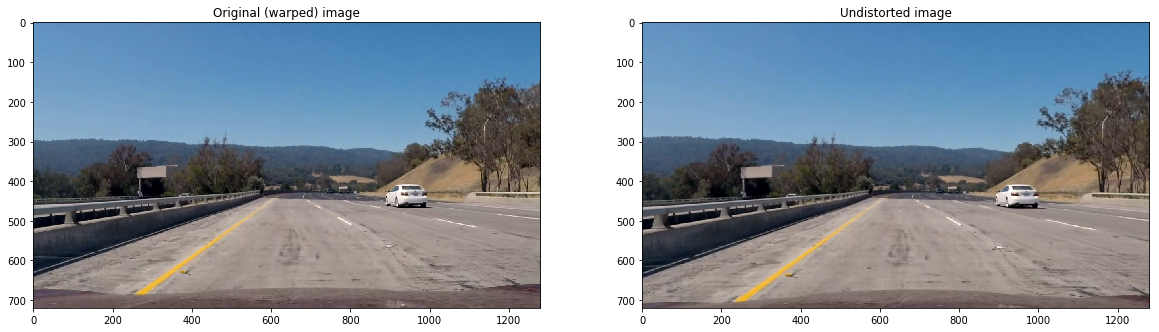

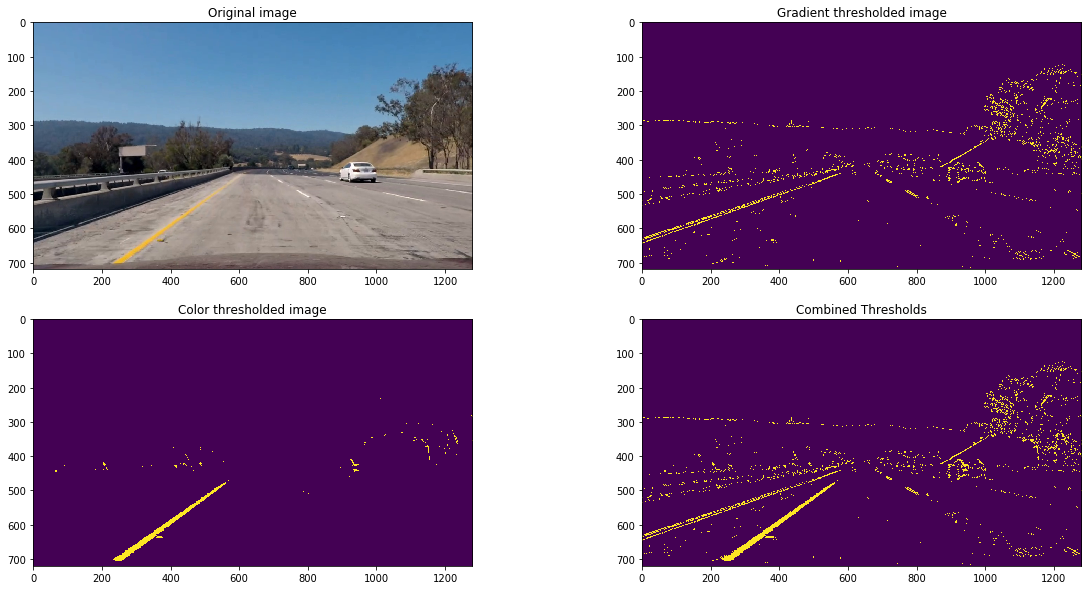

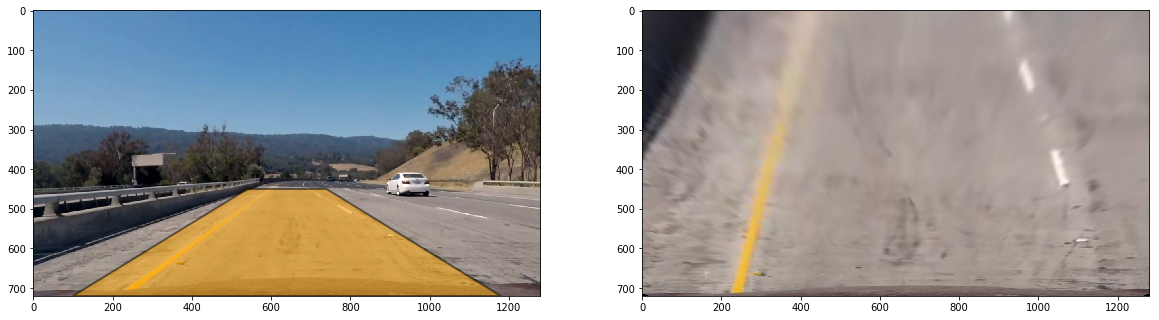

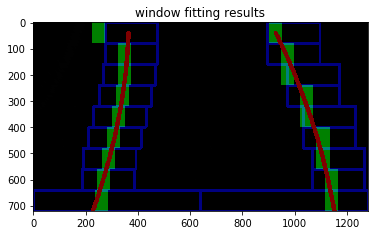

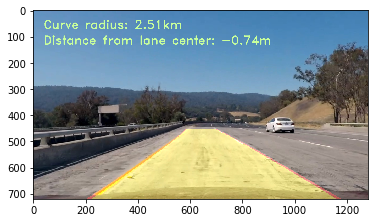

In [ ]:
test_image_fnames = glob.glob('./test_images/*.jpg')
test_image_fnames = ['frame23sec.jpg']
i = 1

for fname in test_image_fnames:
    left_line = Line()
    right_line = Line()
    if i > 3:
        break
    img = cv2.imread(fname)
    b,g,r = cv2.split(img)       # get b,g,r
    original_img = cv2.merge([r,g,b])     # switch it to rgb
    disp_img = pipeline(original_img, mtx, dst, left_line, right_line, display=True)
    plt.imshow(disp_img)
    plt.show()
    i = i+1

## Run the pipeline on the video

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line() # global scope
right_line = Line() # global scope
def process_image(image):
    return pipeline(image,mtx,dst,left_line, right_line)

white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(30,35.5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


 29%|██▉       | 365/1261 [01:43<04:00,  3.73it/s]

## Helper code to extract particular frames from the video

In [ ]:
import cv2

vidcap = cv2.VideoCapture('project_video.mp4')
vidcap.set(cv2.CAP_PROP_POS_MSEC,23000)      # just cue to 30 sec. position
success,image = vidcap.read()
if success:
    cv2.imwrite("frame23sec.jpg", image)     # save frame as JPEG file
    img = cv2.imread("frame23sec.jpg")
    b,g,r = cv2.split(img)       # get b,g,r
    original_img = cv2.merge([r,g,b])     # switch it to rgb
    undist=cv2.undistort(img,mtx,dst)
    transformed_img, src_pts, M = perspective_rectify(undist)
    display_perspective_transform(undist, src_pts, transformed_img)